# Data & Env Initialization

In [1]:
import os, sys, gc

import zipfile
from os import path
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt

zip_file = "Sky303.zip"
data_path = "Sky303/"

input_indice_path = data_path + "input_indices_{}.npy"
input_data_path = data_path + "input_data_{}.npy"
target_path = data_path + "output_indices_{}.npy"
if not path.exists(data_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(".")

# Constants

In [2]:
# THETA = [2.5, -1.25, 0.] # the theta of the problem describle in the paper
N_CONFIGURATIONS = 4262 # number of configuration of the problem
IMG_SHAPE = (1355, 3384, 3)
H, W = 128, 256 # the window size

CAMERA = np.array([[2304.5479, 0,  1686.2379], # the camera matrix
                          [0, 2305.8757, -0.0151],
                          [0, 0, 1.]], dtype=np.float32)

# Data Viz & Utils

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.__version__

'1.3.1+cu92'

In [4]:
class Sky303Dataset(Dataset):
    """Car dataset."""

    def __init__(self):
        super(Sky303Dataset,self).__init__()

    def __len__(self):
        return N_CONFIGURATIONS

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        indice_np = np.load(input_indice_path.format(idx))
        input_np = np.load(input_data_path.format(idx))
        target_np = np.load(target_path.format(idx))
        
        input_bin_mask = np.zeros([H, W, 1], dtype='float16')
        input_bin_mask[indice_np[:,0],indice_np[:,1],:] = 1.
        
        input_2Drepr = np.zeros([H, W, 3], dtype='float16')
        input_2Drepr[indice_np[:,0],indice_np[:,1],:] = input_np
        
        target_2Drepr = np.zeros([H, W, 1], dtype='float16')
        target_2Drepr[target_np[:,0],target_np[:,1],:] = 1.
        
        input_bin_mask = np.rollaxis(input_bin_mask, 2, 0)
        input_bin_mask = torch.from_numpy(input_bin_mask).float()
        
        input_2Drepr = np.rollaxis(input_2Drepr, 2, 0)
        input_2Drepr = torch.from_numpy(input_2Drepr).float()
        
        target_2Drepr = np.rollaxis(target_2Drepr, 2, 0)
        target_2Drepr = torch.from_numpy(target_2Drepr).float()
        
        return [input_bin_mask, input_2Drepr, target_2Drepr]

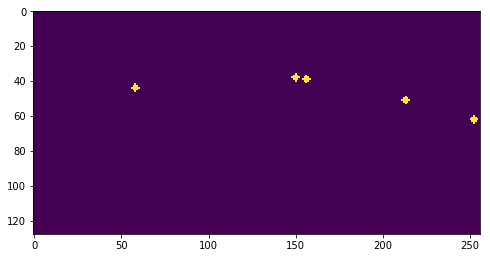

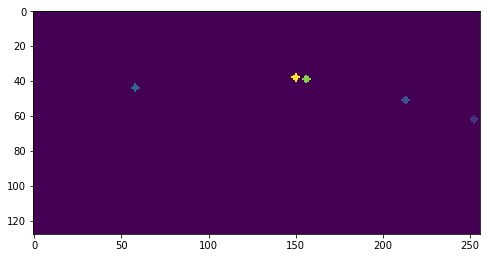

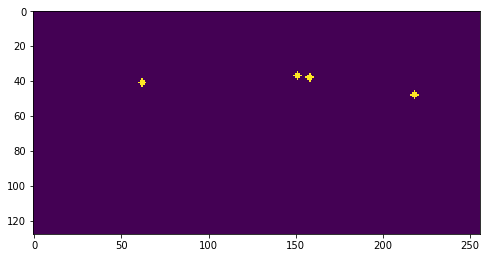

In [5]:
dataset = Sky303Dataset()
input_bin_mask, input_2Drepr, target_2Drepr = dataset[0]

plt.figure(figsize=(8,8))
plt.imshow((input_bin_mask.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(input_2Drepr.permute(1,2,0).numpy()[:,:,-1]/350.)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow((target_2Drepr.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

# Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    return x[tuple(slice(None, None) if i != dim
             else torch.arange(x.size(i)-1, -1, -1).long()
             for i in range(x.dim()))]

class SMap3x3(nn.Module):
    def __init__(self, camera_matrix):
        super(SMap3x3,self).__init__()
        self.camera_matrix = nn.Parameter(torch.from_numpy(camera_matrix), requires_grad=False)
        self.camera_matrix_inv = nn.Parameter(torch.from_numpy(np.linalg.inv(camera_matrix)), requires_grad=False)

        self.sm = nn.Softmax(dim=2)
    
    def to_3d(self, z, height, width, panels, original_size):
        y_im, x_im = panels
        y_im, x_im = torch.from_numpy(y_im).reshape(height, width), torch.from_numpy(x_im).reshape(height, width)
        y_im = y_im * IMG_SHAPE[0] / original_size[0]
        x_im = x_im * IMG_SHAPE[1] / original_size[1]
        y_im, x_im = y_im.to(device), x_im.to(device)
        
        imp_co = torch.cat([torch.einsum('hw,bczhw->bczhw', x_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.einsum('hw,bczhw->bczhw', y_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.ones_like(z.unsqueeze(2))], 2)
        imp_co = F.unfold(imp_co.reshape(1, -1, height, width), kernel_size=(3,3), stride=(1,1), padding=(1,1), dilation=(1,1)).reshape(z.size(0),z.size(1),3,3*3,height,width)
        imp_co = torch.einsum('bchw,bczshw->bczshw', z.float(), imp_co.float()).reshape(z.size(0),z.size(1),3,3*3,-1)
        regr_co = torch.einsum('xz,yz->xy', imp_co.reshape(z.size(0),z.size(1),3,-1).permute(0,1,3,2).reshape(-1,3).float(), self.camera_matrix_inv.float())
        regr_co = regr_co.reshape(z.size(0),z.size(1),-1,3).permute(0,1,3,2).reshape(z.size(0),z.size(1),3,3*3,height*width)
        return regr_co
    
    def agg(self, x, ind=None, factor=0.):
        x = x + ((x>0.).float()-1.)*(-factor)
        
        sizes = list(x.size())
        sizes[2] = 1
        sizes[3] = 1
        
        y01 = torch.cat([(x[:,:,0,1,:,1:,:]), torch.ones_like(x[:,:,0,1,:,:1,:])*factor],dim=-2).reshape(*sizes)
        y21 = torch.cat([torch.ones_like(x[:,:,2,1,:,-1:,:])*factor, (x[:,:,2,1,:,:-1,:])],dim=-2).reshape(*sizes)
        y10 = torch.cat([(x[:,:,1,0,:,:,1:]), torch.ones_like(x[:,:,1,0,:,:,:1])*factor],dim=-1).reshape(*sizes)
        y12 = torch.cat([torch.ones_like(x[:,:,1,2,:,:,-1:])*factor, (x[:,:,1,2,:,:,:-1])],dim=-1).reshape(*sizes)
        
        y00 = torch.cat([(x[:,:,0,0,:,1:,:]), torch.ones_like(x[:,:,0,0,:,:1,:])*factor],dim=-2).reshape(*sizes)
        y00 = torch.cat([(y00[:,:,0,0,:,:,1:]), torch.ones_like(y00[:,:,0,0,:,:,:1])*factor],dim=-1).reshape(*sizes)
        
        y02 = torch.cat([(x[:,:,0,2,:,1:,:]), torch.ones_like(x[:,:,0,2,:,:1,:])*factor],dim=-2).reshape(*sizes)
        y02 = torch.cat([torch.ones_like(y02[:,:,0,0,:,:,-1:])*factor, (y02[:,:,0,0,:,:,:-1])],dim=-1).reshape(*sizes)
        
        y20 = torch.cat([torch.ones_like(x[:,:,2,0,:,-1:,:])*factor, (x[:,:,2,0,:,:-1,:])],dim=-2).reshape(*sizes)
        y20 = torch.cat([(y20[:,:,0,0,:,:,1:]), torch.ones_like(y20[:,:,0,0,:,:,:1])*factor],dim=-1).reshape(*sizes)
        
        y22 = torch.cat([torch.ones_like(x[:,:,2,2,:,-1:,:])*factor, (x[:,:,2,2,:,:-1,:])],dim=-2).reshape(*sizes)
        y22 = torch.cat([torch.ones_like(y22[:,:,0,0,:,:,-1:])*factor, (y22[:,:,0,0,:,:,:-1])],dim=-1).reshape(*sizes)
        y11 = (x[:,:,1,1,:,:,:]).reshape(*sizes)
        
        sizes[2] = 3*3
        sizes[3] = 1
        
        x = torch.cat([y00,y01,y02,y10,y11,y12,y20,y21,y22],dim=2).reshape(*sizes)

        if ind is None:
            return x
        if sizes[4] == 3:
            sizes[4] = 1
            x0 = (x[:,:,:,:,:1,:,:]).reshape(*sizes)
            x1 = (x[:,:,:,:,1:2,:,:]).reshape(*sizes)
            x2 = (x[:,:,:,:,2:,:,:]).reshape(*sizes)
            
            sizes[2] = 1
            sizes[3] = 1
            
            x0 = torch.sum(torch.where(ind,x0,torch.zeros_like(x0)),dim=2,keepdim=True)
            x1 = torch.sum(torch.where(ind,x1,torch.zeros_like(x1)),dim=2,keepdim=True)
            x2 = torch.sum(torch.where(ind,x2,torch.zeros_like(x2)),dim=2,keepdim=True)
            
            return torch.cat([x0.reshape(*sizes), x1.reshape(*sizes), x2.reshape(*sizes)], dim=4)
        
        sizes[2] = 1
        sizes[3] = 1
        return torch.sum(torch.where(ind,x,torch.zeros_like(x)),dim=2,keepdim=True).reshape(*sizes)
    
    def forward(self, x, r_mask, target_2Dr, original_size):
        shapes = x.size()
        BATCH_SIZE, height, width = shapes[0], shapes[-2], shapes[-1]

        x_z_value = torch.cat([x, r_mask], dim=2)
        
        # 
        height = height + 2**0 + 2**0
        width = width + 2**0 + 2**0
        
        x_z_value = torch.cat([torch.zeros_like(x_z_value[:,:,:,:,:(2**0)]), x_z_value, torch.zeros_like(x_z_value[:,:,:,:,:(2**0)])], dim=-1)
        x_z_value = torch.cat([torch.zeros_like(x_z_value[:,:,:,:(2**0),:]), x_z_value, torch.zeros_like(x_z_value[:,:,:,:(2**0),:])], dim=-2)

        panels = list(np.where(np.ones([height, width])))
        offset_codes = ((height-original_size[0]), (width-original_size[1]))
        panels[0] = panels[0] - (offset_codes[0]//2) + .5
        panels[1] = panels[1] - (offset_codes[1]//2) + .5

        # 
        z_values = (x_z_value[:,:,2:3,:,:]).reshape(BATCH_SIZE,-1,1,height, width).detach().clone()
        r_mask = (x_z_value[:,:,3:4,:,:]).reshape(BATCH_SIZE,-1,1,height, width)
        x_z_value = x_z_value[:,:,:3,:,:].reshape(BATCH_SIZE,-1,3,height, width)
        grouped_key = x_z_value.reshape(BATCH_SIZE,-1,3,1,height*width)

        updated_key_z = self.to_3d(z_values.reshape(BATCH_SIZE,-1,height, width), height, width, panels, original_size)
        query = updated_key_z.reshape(BATCH_SIZE,-1,3,3*3,height*width).reshape(BATCH_SIZE,-1,3,3*3,height*width).detach().clone()

        key_query = torch.sum(torch.abs(grouped_key[:,:,:2,:,:]-query[:,:,:2,:,:]),dim=2).reshape(BATCH_SIZE,-1,3*3,height, width)
        
        weights_b = torch.zeros_like(key_query)
        _, ind = torch.max(-key_query,dim=2,keepdim=True)
        ind_mask = F.one_hot(ind, num_classes=3*3).reshape(BATCH_SIZE,-1,height, width,3*3).permute(0,1,4,2,3).reshape(BATCH_SIZE,-1,3*3,height, width)
        weights_b[ind_mask>.5] = 1.
        weights_b = (weights_b*r_mask).reshape(BATCH_SIZE,-1,3,3,height, width)
        new_x_z_value = torch.einsum('bcsthw,bczhw->bcstzhw', weights_b.detach().clone(), x_z_value)
        new_z_values = torch.einsum('bcsthw,bczhw->bcstzhw', weights_b, z_values).detach().clone()
        
        ind = self.agg(new_z_values, factor=1e7)
        _, ind = torch.min(ind,dim=2,keepdim=True)
        ind = F.one_hot(ind, num_classes=3*3).reshape(BATCH_SIZE,-1,1,1,height, width,3*3).permute(0,1,6,2,3,4,5).reshape(BATCH_SIZE,-1,3*3,1,1,height, width)
        ind = (ind>.5)
        new_x_z_value = self.agg(new_x_z_value, ind=ind).reshape(-1,3,height, width)
        new_r_mask = self.agg(weights_b.reshape(BATCH_SIZE,-1,3,3,1,height, width), ind=ind).reshape(-1,1,height, width)
        weights = None
        
        if target_2Dr is not None:
            shapes = target_2Dr.size()
            BATCH_SIZE, C_zoom, h_zoom, w_zoom = shapes[0], shapes[1], shapes[-2], shapes[-1]
            
            target_2Dr, _ = torch.max(target_2Dr.reshape(batch_size,-1,1,h_zoom, w_zoom),dim=1,keepdim=False)

            weights = weights_b.reshape(BATCH_SIZE,C_zoom,3*3,height, width)+(key_query.detach().clone()-key_query).reshape(BATCH_SIZE,C_zoom,3*3,height, width)
            weights = weights.reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)*r_mask.reshape(BATCH_SIZE,C_zoom,1,1,1,height, width)
            weights = self.agg(weights).reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)
            
            allow = torch.ones_like(weights).reshape(BATCH_SIZE,C_zoom,3*3,1,height, width)
            allow[:,:,:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)] = (weights.reshape(BATCH_SIZE,C_zoom,3*3,1,height, width)[:,:,:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)])*target_2Dr.reshape(BATCH_SIZE,1,1,1,h_zoom, w_zoom)
            allow = self.agg(flip(allow,2).reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)).reshape(BATCH_SIZE,C_zoom,3*3,1,1,height, width)
            allow = torch.max(allow,dim=2,keepdim=True)[0]
            allow = 1.-allow
            allow = torch.cat([allow, allow, allow],dim=2)
            allow = torch.cat([allow, allow, allow],dim=3).reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)
            allow = (self.agg(allow).reshape(BATCH_SIZE,-1,height, width)[:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)]).reshape(BATCH_SIZE,-1,h_zoom, w_zoom)
            
            new_x_z_value = None
            weights = (weights.reshape(BATCH_SIZE,-1,height, width)[:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)]).reshape(BATCH_SIZE,-1,h_zoom, w_zoom)
            new_r_mask = (new_r_mask[:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)]).reshape(BATCH_SIZE,-1,h_zoom, w_zoom)
            
            weights = weights.detach().clone() + (weights-weights.detach().clone())*allow.detach().clone()*target_2Dr.reshape(BATCH_SIZE,1,h_zoom, w_zoom)
            
        return new_x_z_value, new_r_mask, weights

class SMap(nn.Module):
    def __init__(self, n, camera_matrix):
        super(SMap,self).__init__()
        self.n = n
        self.smap3x3 = SMap3x3(camera_matrix)
    
    def forward(self, x, r_mask, target_2Dr=None, zoom=0):
        shapes = x.size()
        BATCH_SIZE, height, width = shapes[0], shapes[2], shapes[3]
        C_zoom = 2**(self.n+self.n)
        C_zoom_2 = 2**self.n
        height_zoom = height // (2**self.n)
        width_zoom = width // (2**self.n)

        x = x.reshape(BATCH_SIZE,3,height_zoom,C_zoom_2, width_zoom,C_zoom_2).permute(0,3,5,1,2,4).reshape(BATCH_SIZE,C_zoom,3,height_zoom, width_zoom)
        r_mask = r_mask.detach().clone().reshape(BATCH_SIZE,1,height_zoom,C_zoom_2, width_zoom,C_zoom_2).permute(0,3,5,1,2,4).reshape(BATCH_SIZE,C_zoom,1,height_zoom, width_zoom)
        
        target = None
        if target_2Dr is not None:
            target_2Dr = target_2Dr.reshape(batch_size,1,height_zoom,C_zoom_2, width_zoom,C_zoom_2).permute(0,3,5,1,2,4).reshape(batch_size,C_zoom,1,height_zoom, width_zoom)
            if self.n==zoom:
                target = target_2Dr.reshape(batch_size,-1,height_zoom, width_zoom)
        x, r_mask, weights = self.smap3x3(x, r_mask, target, (height_zoom, width_zoom))
        _, _, h_out, w_out = r_mask.size()
        
        for i in range(self.n-zoom):
            C_zoom = C_zoom//4
            C_zoom_2 = C_zoom_2//2
            height_zoom = height_zoom*2
            width_zoom = width_zoom*2
            h_out = h_out*2
            w_out = w_out*2
            x = x.reshape(-1,2,C_zoom_2,2,C_zoom_2,3,h_out//2, w_out//2).permute(0,2,4,5,6,1,7,3).reshape(-1,C_zoom,3,h_out, w_out)
            r_mask = r_mask.reshape(-1,2,C_zoom_2,2,C_zoom_2,1,h_out//2, w_out//2).permute(0,2,4,5,6,1,7,3).reshape(-1,C_zoom,1,h_out, w_out)
            if target_2Dr is not None:
                target_2Dr = target_2Dr.reshape(batch_size,2,C_zoom_2,2,C_zoom_2,1,height_zoom//2, width_zoom//2).permute(0,2,4,5,6,1,7,3).reshape(batch_size,C_zoom,height_zoom, width_zoom)
                if i==(self.n-zoom-1):
                    target = target_2Dr.reshape(batch_size,-1,height_zoom, width_zoom)

            x, r_mask, weights = self.smap3x3(x, r_mask, target, (height_zoom, width_zoom))
            _, _, h_out, w_out = r_mask.size()
        
        return r_mask, weights

class Model(nn.Module):
    def __init__(self, camera_matrix, n=0):
        super(Model,self).__init__()
        self.n = n
        
        self.phi = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.gamma = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.rho = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.theta = nn.Parameter(torch.from_numpy(np.array([0.,-0.,0.])).float().reshape(1,3,1,1), requires_grad=True)
        self.smap_layer = SMap(n, camera_matrix)
        
        self.I00 = nn.Parameter(torch.from_numpy(np.array([[1.,.0,.0],[.0,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I01 = nn.Parameter(torch.from_numpy(np.array([[0.,1.,.0],[.0,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I10 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[1.,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I11 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[.0,1.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I22 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[.0,0.,.0],[.0,.0,1.]])).float().reshape(3,3), requires_grad=False)
        
    def forward(self, x, r_mask, target_2Dr=None, zoom=0):
        phi = torch.tanh(3e-2*self.phi)*np.pi
        gamma = torch.tanh(3e-2*self.gamma)*np.pi
        rho = torch.tanh(3e-2*self.rho)*np.pi
        r = torch.cos(phi)*self.I00-torch.sin(phi)*self.I01+torch.sin(phi)*self.I10+torch.cos(phi)*self.I11+self.I22
        y = torch.cos(gamma)*self.I00-torch.sin(gamma)*self.I01+torch.sin(gamma)*self.I10+torch.cos(gamma)*self.I11+self.I22
        p = torch.cos(rho)*self.I00-torch.sin(rho)*self.I01+torch.sin(rho)*self.I10+torch.cos(rho)*self.I11+self.I22
        
        x_r = torch.einsum('bdef,cd->bcef',x,r.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x),(r-r.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        x_r = torch.einsum('bdef,cd->bcef',x_r,y.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x_r),(y-y.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        x_r = torch.einsum('bdef,cd->bcef',x_r,p.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x_r),(p-p.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        
        x_t = x_r.detach()+r_mask*self.theta
        
        x_t = x+torch.where(r_mask>0.,x_t-x,torch.zeros_like(r_mask))
        k_t = torch.where((x_t[:,-1:,:,:])>0.,5./x_t[:,-1:,:,:],torch.ones_like(x_t[:,-1:,:,:]))
        
        x_r = x_r+r_mask*self.theta.detach()

        r_mask, weights = self.smap_layer(k_t*x_t+(x_r-x_r.detach()), r_mask, target_2Dr, zoom)

        return phi, gamma, rho, r_mask, weights

In [8]:
def create_model(camera_matrix, n):
    return Model(camera_matrix, n)

# Datasets

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SequentialSampler, SubsetRandomSampler

In [10]:
train_idx, valid_idx= train_test_split(
    np.random.choice(np.arange(N_CONFIGURATIONS), size=512, replace=False), test_size=0.25, random_state=0, shuffle=True)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SequentialSampler(valid_idx)

# Training

In [11]:
def l1_error(pred, target):
    shapes = target.size()
    m_batch_size, height, width = shapes[0], shapes[-2], shapes[-1]
    
    pred = pred.reshape(m_batch_size, -1, height*width)
    pred_m, _ = torch.max(pred.reshape(m_batch_size, -1, height*width),dim=1,keepdim=True)
    target = target.reshape(m_batch_size, 1, -1)
    target_m = target.reshape(m_batch_size, 1, -1)
    
    loss = torch.abs(pred-target)
    loss_m = torch.abs(pred_m-target_m)*pred_m
    
    loss = loss.reshape(m_batch_size, -1).sum(dim=1)
    loss_m = loss_m.reshape(m_batch_size, -1).sum(dim=1)
    
    loss = torch.mean(loss_m).detach().clone()+(loss-loss.detach().clone()).sum()
    return loss

def train_loop_fn(loader, zoom, epoch, history=None):
    model.train()
    for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
        m_batchsize = r_mask_batch.size(0)
        if m_batchsize != batch_size:
            break
        else:
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

        optimizer.zero_grad()
        
        r, p, y, r_mask, weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch, zoom)
        
        target_2Dr = target_2Dr_batch.reshape(m_batchsize,1,H//(2**zoom),(2**zoom),W//(2**zoom),(2**zoom)).permute(0,3,5,1,2,4).reshape(m_batchsize,(2**(zoom+zoom)),1,H//(2**zoom),W//(2**zoom))
        target_2Dr, _ = torch.max(target_2Dr,dim=1,keepdim=False)

        loss = l1_error(weights, target_2Dr)

        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        history.loc[(zoom, epoch, batch_idx), 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'theta_z'] = (model.theta[0,2,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'phi'] = (r[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'gamma'] = (p[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'rho'] = (y[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'loss'] = loss_np
        
    print('Train Epoch: ({}, {}) \tLR: {:.6f}\tLoss: {:.6f}'.format(
            zoom, epoch,
            optimizer.state_dict()['param_groups'][0]['lr'],
            history['loss'].iloc[(-len(train_loader)+1):].mean()))
    
def evaluate_model(loader, key, history=None):
    model.eval()
    loss_np = 0.
    count = 0.

    with torch.no_grad():
        for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
            m_batchsize = r_mask_batch.size(0)
            if m_batchsize != batch_size:
                break
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

            optimizer.zero_grad()

            r, p, y, r_mask, weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch)
            
            l1 = l1_error(weights, target_2Dr_batch)
            loss_np += l1.detach().cpu().numpy()
            count = count+1.
    loss_np /= count
    history.loc[key, 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
    history.loc[key, 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
    history.loc[key, 'theta_z'] = (model.theta[0,2,0,0]).detach().cpu().numpy()
    history.loc[key, 'phi'] = (r[0,0]).detach().cpu().numpy()
    history.loc[key, 'gamma'] = (p[0,0]).detach().cpu().numpy()
    history.loc[key, 'rho'] = (y[0,0]).detach().cpu().numpy()
    history.loc[key, 'dev_loss'] = loss_np
    print("n_epochs: {} - lr: {}".format(*key))
    print('theta_x: {:.4f}'.format((model.theta[0,0,0,0]).detach().cpu().numpy()))
    print('theta_y: {:.4f}'.format((model.theta[0,1,0,0]).detach().cpu().numpy()))
    print('theta_z: {:.4f}'.format((model.theta[0,2,0,0]).detach().cpu().numpy()))
    print('phi: {:.4f}'.format((r[0,0]).detach().cpu().numpy()))
    print('gamma: {:.4f}'.format((p[0,0]).detach().cpu().numpy()))
    print('rho: {:.4f}'.format((y[0,0]).detach().cpu().numpy()))
    print('Dev loss: {:.4f}'.format(loss_np))

In [12]:
import time
%time


n_epochs_list = [2]
lr_list = [1e-3]
batch_size = 16
n = 4
optimizer = None
model = None


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=valid_sampler)

fileName = None
dev_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['epoch', 'lr']), columns=['theta_x', 'theta_y', 'theta_z', 'dev_loss'])

torch.cuda.empty_cache()
gc.collect()

for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        n_epochs = n_epochs_list[i_epoch]
        lr = lr_list[i_lr]
        train_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['zoom', 'epoch', 'batch_id']), columns=['theta_x', 'theta_y', 'theta_z', 'loss'])

        model = create_model(CAMERA, n)
        if fileName is not None:
            state_dict = torch.load(fileName, map_location='cpu')
            model.load_state_dict(state_dict, strict=False)
            del state_dict
            print("Loaded!!")
        model = model.to(device)

        torch.cuda.empty_cache()

        gc.collect()
        optimizer = optim.SGD(list(model.parameters()), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs, gamma=.5)

        torch.cuda.empty_cache()
        gc.collect()

        for i in range(n+1):
            for epoch in range(n_epochs):
                zoom = n-i
                torch.cuda.empty_cache()
                gc.collect()

                loader = train_loader
                train_loop_fn(loader, zoom, epoch, train_history)
                
            scheduler.step()

        loader = dev_loader
        start = time.time()*1000.0
        evaluate_model(loader, (n_epochs, lr), dev_history)
        t_interval = time.time()*1000.0 - start
        print("Speed: {} ms/sample".format(t_interval/(len(dev_loader)*batch_size)))

        gc.collect()
        optimizer = None
        gc.collect()

        train_history.to_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        torch.save(model.state_dict(), "./model_{}_{}.pth".format(i_epoch, i_lr))
dev_history.to_csv('dev_history.csv')

Wall time: 0 ns


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.001000	Loss: 0.934783


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (4, 1) 	LR: 0.001000	Loss: 0.497283


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.001000	Loss: 1.105978


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (3, 1) 	LR: 0.001000	Loss: 1.179348


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000500	Loss: 3.059783


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (2, 1) 	LR: 0.000500	Loss: 2.421196


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000500	Loss: 4.035326


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (1, 1) 	LR: 0.000500	Loss: 1.559783


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000250	Loss: 2.209239


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Train Epoch: (0, 1) 	LR: 0.000250	Loss: 1.008152


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/it]

n_epochs: 2 - lr: 0.001
theta_x: 0.5153
theta_y: -0.3037
theta_z: 0.0003
phi: 0.0000
gamma: -0.0000
rho: -0.0000
Dev loss: 1.1719
Speed: 68.37523651123047 ms/sample


# Result Visualization

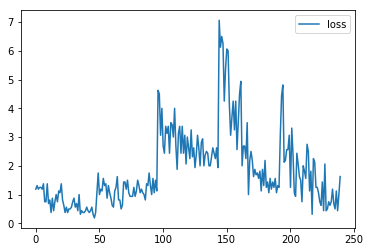

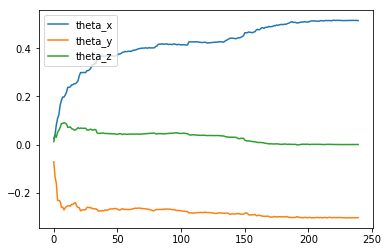

In [13]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot();
        train_history[['theta_x', 'theta_y', 'theta_z']].plot();

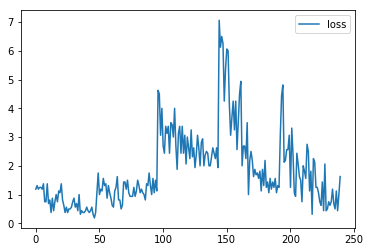

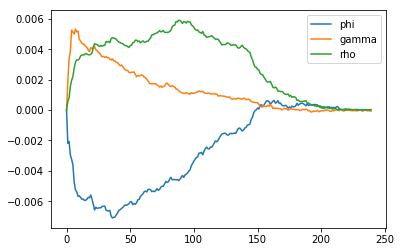

In [14]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot();
        train_history[['phi', 'gamma', 'rho']].plot();

In [15]:
dev_history

,,theta_x,theta_y,theta_z,dev_loss,phi,gamma,rho
epoch,lr,,,,,,,
2,0.001,0.5152504,-0.30370212,0.00033973268,1.17188,0.000047,-0.000033,-0.000006


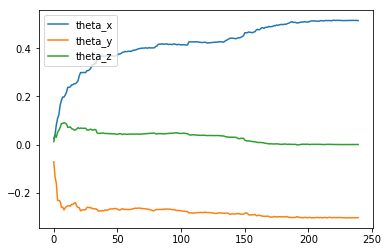

In [18]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        ax = train_history[['theta_x', 'theta_y', 'theta_z']].plot()
        fig = ax.get_figure()
        fig.savefig('./position.png')

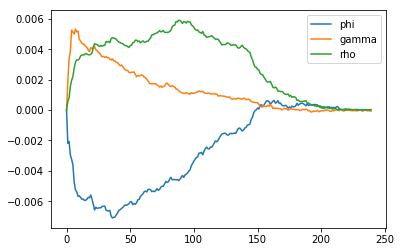

In [19]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        ax = train_history[['phi', 'gamma', 'rho']].plot()
        fig = ax.get_figure()
        fig.savefig('./orientation.png')